In [2]:
import os
import sys
import argparse
import numpy as np
import numba as nb
import scipy.stats
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tools import merge_matrix, hic_norm, clean_matrix

@nb.jit()
def down_sample_but_same_size(matrix, ratio):
    dim = matrix.shape
    _l = int(dim[0]/ratio)
    _m = np.zeros((dim[0], dim[0]))
    for i in range(_l):
        for j in range(_l):
            _m[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio] = matrix[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio].mean()
    return _m

In [3]:
chrom = 19
train_folder = '/data1/lmh_data/MMSR_complete/train/'
validation_folder = '/data1/lmh_data/lab/train/validation'

hr_path = os.path.join(train_folder, 'hr', 'chr{}_1000b.npz'.format(chrom))
complete_path = os.path.join(train_folder, 'replaced', 'chr{}_1000b.npz'.format(chrom))
result_path = os.path.join(validation_folder, 'chr{}_1kb.npz'.format(chrom))

In [4]:
hr = np.load(hr_path)['hic'].astype(float)
complete = np.load(complete_path)['hic'].astype(float)
result = np.load(result_path)['out'].astype(float)

In [5]:
print(hr.shape)
print(complete.shape)
print(result.shape)

(147, 5, 400, 400)
(147, 5, 400, 400)
(147, 5, 400, 400)


In [6]:
for i in range(result.shape[0]):
    result[i][0] = (result[i][0] + result[i][0].T)/2

hr = merge_matrix(hr)
complete = merge_matrix(complete)
result = merge_matrix(result)

hr = np.triu(hr).T + np.triu(hr)
complete = np.triu(complete).T + np.triu(complete)
result = np.triu(result).T + np.triu(result)

low5 = down_sample_but_same_size(hr, 5)
low10 = down_sample_but_same_size(hr, 10)

hr = hic_norm(hr)
complete = hic_norm(complete)
low5 = hic_norm(low5)
low10 = hic_norm(low10)

# low5 = merge_matrix(low5)
# low10 = merge_matrix(low10)

matrixs, Min = clean_matrix([hr, complete, result, low5, low10])

In [7]:
@nb.jit()
def down_sample(matrix, ratio):
    dim = matrix.shape
    _l = int(dim[0]/ratio)
    _m = np.zeros((_l, _l))
    for i in range(_l):
        for j in range(_l):
            _m[i, j] = matrix[i*ratio:(i+1)*ratio, j*ratio:(j+1)*ratio].mean()
    return _m

dowm_hr = down_sample(matrixs[0], 10)
dowm_complete = down_sample(matrixs[1], 10)
down_result = down_sample(matrixs[2], 10)

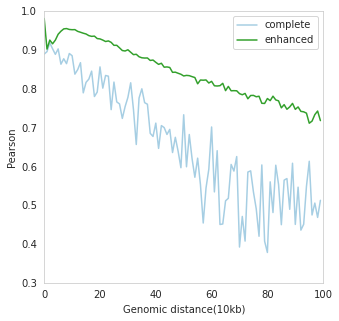

complete_y: 0.6595845329823475
enhanced: 0.8436130129459479


In [14]:
# fig4: 10kb PCC
distance_all = [[0, chrom]]
dic_norm = {}
length = 100 # 1mb
for i in range(length):
    dic_norm[i]=[[], [], []]
for i in range(len(distance_all)):
    for j in range(-length+1, length, 1):
        dis = distance_all[i][0] - j
        dic_norm[abs(dis)][0]+=dowm_hr.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][1]+=dowm_complete.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][2]+=down_result.diagonal(offset=j).tolist()

complete_y, result_y = [], []
for i in range(length):
    complete_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][1])[0])
    result_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][2])[0])

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(100)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(100)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0.3, 1)
plt.xlabel('Genomic distance(10kb)')
plt.ylabel('Pearson')
plt.xlim(0, 100)
plt.legend()
plt.savefig('fig/fig4_10kb_PCC.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))

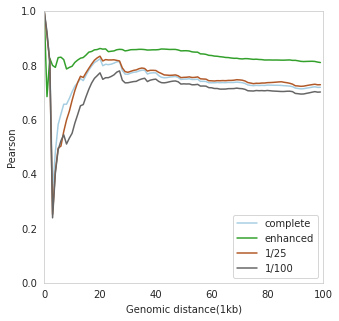

complete_y: 0.7425376161164785
enhanced: 0.8355758276880338
low5_y: 0.7441900666180592
low10_y: 0.7064691193197393


In [15]:
# fig4: 1kb PCC
@nb.jit(nopython=True)
def make_PCCscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _s = np.corrcoef(matrix1[begin-i:begin+i, begin-i:begin+i].flatten(), matrix2[begin-i:begin+i, begin-i:begin+i].flatten())[0, 1]
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_PCCscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_PCCscore(matrixs[0], matrixs[2], begin, radius)
low5_y = make_PCCscore(matrixs[0], matrixs[3], begin, radius)
low10_y = make_PCCscore(matrixs[0], matrixs[4], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')
axes.plot(list(range(radius)), low5_y, color=(177/255, 89/255, 40/255), label='1/25')
axes.plot(list(range(radius)), low10_y, color=(102/255, 102/255, 102/255), label='1/100')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('Pearson')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig4_1kb_PCC.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))
print("low5_y: {}".format(np.mean(low5_y)))
print("low10_y: {}".format(np.mean(low10_y)))

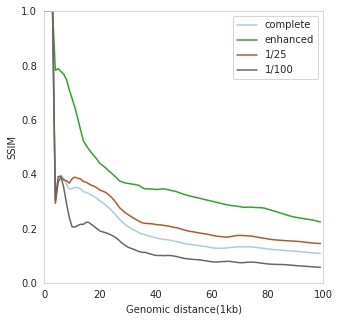

complete_y: 0.21806649134442302
enhanced: 0.38649388831883924
low5_y: 0.25615604187235996
low10_y: 0.15561549703750097


In [16]:
# fig4: 1kb ssim
# @nb.jit(nopython=True)
def make_SSIMscore(matrix1, matrix2, begin, radius):
    scores = [1]*4
    for i in range(4, radius):
        _s = structural_similarity(matrix1[begin-i:begin+i, begin-i:begin+i], matrix2[begin-i:begin+i, begin-i:begin+i])
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_SSIMscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_SSIMscore(matrixs[0], matrixs[2], begin, radius)
low5_y = make_SSIMscore(matrixs[0], matrixs[3], begin, radius)
low10_y = make_SSIMscore(matrixs[0], matrixs[4], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')
axes.plot(list(range(radius)), low5_y, color=(177/255, 89/255, 40/255), label='1/25')
axes.plot(list(range(radius)), low10_y, color=(102/255, 102/255, 102/255), label='1/100')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('SSIM')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig4_1kb_SSIM.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))
print("low5_y: {}".format(np.mean(low5_y)))
print("low10_y: {}".format(np.mean(low10_y)))

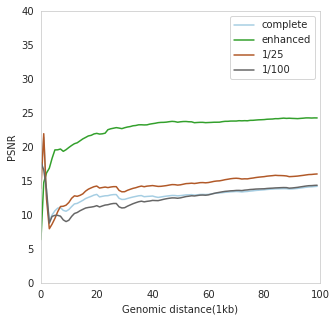

complete_y: 12.992373945258516
enhanced: 22.677886956649953
low5_y: 14.389067102443873
low10_y: 12.530045876671377


In [17]:
# fig4: 1kb psnr
# @nb.jit(nopython=True)
def make_PSNRscore(matrix1, matrix2, begin, radius):
    scores = []
    for i in range(0, radius):
        _m1 = matrix1[begin-i:begin+i+1, begin-i:begin+i+1]
        _m2 = matrix2[begin-i:begin+i+1, begin-i:begin+i+1]
        _range = max(_m1.max(), _m2.max())
        _s = peak_signal_noise_ratio(_m1, _m2, data_range=_range)
        if np.isnan(_s):
            _s = 1
        scores.append(_s)
    return scores

begin, radius = 920, 100
complete_y = make_PSNRscore(matrixs[0], matrixs[1], begin, radius)
result_y = make_PSNRscore(matrixs[0], matrixs[2], begin, radius)
low5_y = make_PSNRscore(matrixs[0], matrixs[3], begin, radius)
low10_y = make_PSNRscore(matrixs[0], matrixs[4], begin, radius)

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')
axes.plot(list(range(radius)), low5_y, color=(177/255, 89/255, 40/255), label='1/25')
axes.plot(list(range(radius)), low10_y, color=(102/255, 102/255, 102/255), label='1/100')

plt.ylim(0, 40)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('PSNR')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig4_1kb_PSNR.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))
print("low5_y: {}".format(np.mean(low5_y)))
print("low10_y: {}".format(np.mean(low10_y)))

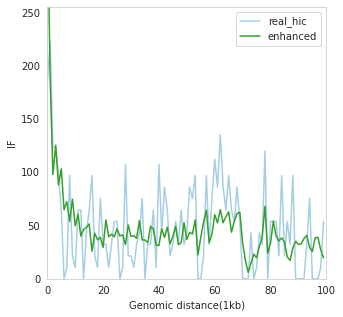

In [19]:
begin, radius = 920, 100
hr_y = matrixs[0][begin, begin:begin+radius]
result_y = matrixs[2][begin, begin:begin+radius]

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(radius)), hr_y, color=(166/255, 206/255, 227/255), label='real_hic')
axes.plot(list(range(radius)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 255)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('IF')
plt.xlim(0, radius)
plt.legend()
plt.savefig('fig/fig4_1kb_IF.pdf')
plt.show()